In [50]:
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertForMaskedLM
import torch
from transformers import AdamW
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors
import pandas as pd
from nltk.tokenize import RegexpTokenizer
import pickle
import ast
import statistics as s
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
import nltk
from transformers import pipeline
import copy
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nynkegpu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# load word2vec model
word2vec_model = Word2Vec.load("word2vec_finetuned.model")
# load BERT model
BERT_model = torch.load('BERT_finetuned.pt')
# load dataframe
df = pd.read_csv('preprocessed_df.csv')

tokenizer = BertTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
#BERT_model = BertForMaskedLM.from_pretrained("GroNLP/bert-base-dutch-cased")
#w2v_model.intersect_word2vec_format(r"combined-160.txt", binary=False, lockf=1.0)
# https://github.com/clips/dutchembeddings

# skiplist (words that should not be corrected: names)
with open("ocr_names.txt", "rb") as fp:   # Unpickling
    ocr_names = pickle.load(fp)

In [38]:
print(len(df))

20


In [39]:
df.columns

Index(['Unnamed: 0', 'identifier', 'gt text', 'ocr text', 'CER', 'WER',
       'WER (order independent)', 'dictionary lookup gt',
       'dictionary lookup ocr', 'jaccard_coefficient',
       'levenshtein_dist_normalized', 'source', 'word count gt',
       'word count ocr', 'year', 'century', 'old index', 'gt text org',
       'ocr text org', 'set', 'gt sentences matched', 'ocr sentences matched',
       'CER matched sentences', 'WER matched sentences',
       'avg sentence length gt (fuzzy matched)',
       'avg sentence length ocr (fuzzy matched)',
       'max sentence length gt (fuzzy matched)',
       'max sentence length ocr (fuzzy matched)',
       'sentences gt (fuzzy matched)', 'sentences ocr (fuzzy matched)',
       'word count gt (fuzzy matched)', 'word count ocr (fuzzy matched)',
       'aligned_GT_sentences', 'aligned_OCR_sentences', 'good_alignments',
       'bad_alignments', 'good alignments percentage', 'longest_streak',
       'avg_longest_streaks', 'avg_total_missing_w

In [40]:
'pannenkoeken' in ocr_names

False

In [41]:
# set hyperparameters for validation
#topn_detection = 1000
#topn_correction = 1000
#window = 5

In [42]:
def list_merger(lists):
    new_list = []
    for elem in lists:
        new_list = new_list + elem
    return new_list

In [43]:
def check_numbers(token):
    numbers = any(char.isdigit() for char in token)
    return numbers

In [44]:
def correct_sorted(candidates, sim_or_probs, LD): # sorts first by LD, then by similarity/probability
    paired_sorted = sorted(zip(LD,sim_or_probs,candidates),key = lambda x: (x[0],x[1]), reverse=True)
    LD,sim_or_probs,candidates = zip(*paired_sorted)
    correction = candidates[0]
    return correction
    
def correct_calculated(candidates, sim_or_probs, LD): # calculates a score from LD and normalised similarity/probability
    inv_LD = 1 - LD
    sim_or_probs = np.array(sim_or_probs)
    sim_or_probs = np.interp(sim_or_probs, (sim_or_probs.min(), sim_or_probs.max()), (0, 1)).tolist()
    score = sim_or_probs / inv_LD
    zipped_pairs = zip(score.tolist(), candidates)
    sorted_by_score = [x for _, x in sorted(zipped_pairs, reverse=True)]
    correction = sorted_by_score[0]
    return correction

def remove_stopwords(candidates, cosine, LD):
    stop_words = set(stopwords.words('dutch'))
    candidates_nostopwords = []
    cosine_nostopwords = []
    LD_nostopwords = []
    for i in range(len(candidates)):
        if candidates[i] not in stop_words:
            candidates_nostopwords.append(candidates[i])
            cosine_nostopwords.append(cosine[i])
            LD_nostopwords.append(LD[i])
    LD_nostopwords = np.array(LD_nostopwords)
    return candidates_nostopwords, cosine_nostopwords, LD_nostopwords

In [45]:
#detection and correction validation word2vec
error_positions = [] # the position of a word when it is an error in predictions
non_error_positions = [] # the position of a word when it is not an error in predictions
right_token_positions = []

rights_correct_sorted_list = []
wrongs_correct_sorted_list = []
rights_correct_sorted_nosw_list = []
wrongs_correct_sorted_nosw_list = []
rights_correct_calculated_list = []
wrongs_correct_calculated_list = []

def detection_and_correction_word2vec(row, w2v_model, ocr_names, window=5, topn_detection=500):
    if row['set'] != 'val':
        return np.nan
    else:
        identifier = row['identifier']
        OCR_text = row['aligned_OCR_sentences']
        GT_text = row['aligned_GT_sentences']
        OCR_text = ast.literal_eval(OCR_text)
        GT_text = ast.literal_eval(GT_text)
        OCR_text = list_merger(OCR_text)
        GT_text = list_merger(GT_text)
        window_range = list(range(0,window))
        window_range = np.array(window_range) - ((window - 1) / 2)
        
        #print(OCR_text)
        
        # keep track of positions in candidates
        error_positions_doc = []
        non_error_positions_doc = []
        right_token_positions_doc = []
        
        # keep track of performance
        rights_correct_sorted = 0
        wrongs_correct_sorted = 0
        rights_correct_sorted_nosw = 0
        wrongs_correct_sorted_nosw = 0
        rights_correct_calculated = 0
        wrongs_correct_calculated = 0
        
        for i in range(len(OCR_text)):
            #print(OCR_text[i])
            try:
                if (OCR_text[i] in ocr_names) or (check_numbers(OCR_text[i]) == True) or (len(OCR_text[i]) <= 2) or (GT_text[i] == 'REMOVED'):
                    continue
                error = True
                if OCR_text[i] == GT_text[i]:
                    error = False
                context = []
                for j in window_range:
                    if (i+j >= 0) and (i+j < len(OCR_text)) and j != 0:
                        #context.append(OCR_text[i+int(j)])
                        if any(str.isdigit(c) for c in  OCR_text[i+int(j)]) == True:
                            context.append('%NUMBER%')
                        elif OCR_text[i+int(j)] in ocr_names:
                            context.append('%NNP%')
                        else:
                            context.append(OCR_text[i+int(j)])
                        #GT_context.append(GT_text[i+int(j)])
                candidates = []
                cosines = []
                # calculate positions detection task
                try:
                    for prediction in w2v_model.predict_output_word(context, topn=topn_detection):
                        candidates.append(prediction[0])
                        cosines.append(prediction[1]) 
                    # remove punctuation except for hyphen from candidates
                    candidates = [re.sub(r'[^\w\d\s\-]+', '', x) for x in candidates]
                    candidates = [x.lower() for x in candidates]
                    try:
                        position = candidates.index(OCR_text[i])
                    except ValueError:
                        position = topn_detection
                    #print('error?', error)
                    if error == True:
                        #print('correction needed:', row['identifier'])
                        # where the error is in the detection list
                        error_positions_doc.append(position)
                        # find where the right word is in the candidates list (same as detection list)
                        try: 
                            position_right_token = candidates.index(GT_text[i])
                        except ValueError: 
                            position_right_token = topn_detection
                        right_token_positions_doc.append(position_right_token)
                        # try two correction methods
                        # first calculate the normalized LDs:
                        LD = np.array([fuzz.ratio(OCR_text[i], word)/100 for word in candidates])
                        # try sorting method
                        correction = correct_sorted(candidates, cosines, LD)
                        if correction == GT_text[i]:
                            rights_correct_sorted += 1
                        elif correction != GT_text[i]:
                            wrongs_correct_sorted += 1
                        # try again the sorting methods, but without stopwords
                        candidates_nostopwords, cosine_nostopwords, LD_nostopwords = remove_stopwords(candidates, cosines, LD)
                        correction = correct_sorted(candidates_nostopwords, cosine_nostopwords, LD_nostopwords)
                        if correction == GT_text[i]:
                            rights_correct_sorted_nosw += 1
                        elif correction != GT_text[i]:
                            wrongs_correct_sorted_nosw += 1
                        # try score calculation method
                        correction = correct_calculated(candidates, cosines, LD)
                        if correction == GT_text[i]:
                            rights_correct_calculated += 1
                        elif correction != GT_text[i]:
                            wrongs_correct_calculated += 1
                    elif error == False:
                        # where the non error is in the detection list
                        non_error_positions_doc.append(position)
                    # calculate positions correction task
                    if error == True:
                        try:
                            right_token_position = candidates.index(GT_text[i])
                            right_token_positions_doc.append(right_token_position)
                        except ValueError:
                            right_token_positions_doc.append(topn_detection)
                        right_token_positions.append(right_token_positions_doc)
                except:
                    pass
            except:
                pass
            
            
    #return error_positions, non_error_positions
    error_positions.append(error_positions_doc)
    non_error_positions.append(non_error_positions_doc)
    right_token_positions.append(right_token_positions_doc)
    
    # add performance to the list
    rights_correct_sorted_list.append(rights_correct_sorted)
    wrongs_correct_sorted_list.append(wrongs_correct_sorted)
    rights_correct_sorted_nosw_list.append(rights_correct_sorted_nosw)
    wrongs_correct_sorted_nosw_list.append(wrongs_correct_sorted_nosw)
    rights_correct_calculated_list.append(rights_correct_calculated)
    wrongs_correct_calculated_list.append(wrongs_correct_calculated)
    
    #return identifier, error_positions, non_error_positions, right_token_positions, rights_correct_sorted_list, wrongs_correct_sorted_list, rights_correct_sorted_nosw_list, wrongs_correct_sorted_nosw_list, rights_correct_calculated_list, wrongs_correct_calculated_list   
    
#for index, row in df.iterrows():
#    detection_word2vec(row)
# df.loc[70]
fake_test_list_GT_aligned = """Een koekenpan of kortweg pan is een platte pan met een lang handvat.
De pan ontleent zijn naam aan het feit dat in zo'n pan pannenkoeken worden gebakken. Ook ander voedsel, zoals vlees, wordt in een koekenpan gebraden"""
fake_test_list_OCR_aligned = """Een hoekenpan of kortweg pan is een platte pan met een hang handvat.
De pan ontleent zijn naam haan het feit dat in zo'n pan pannenkoeken horden gebakken. Ook ander voedsel, zoals vlees, word in een hoekenpan gebraden"""
fake_test_list_GT_aligned = fake_test_list_GT_aligned.split('.')
fake_test_list_OCR_aligned = fake_test_list_OCR_aligned.split('.')
fake_test_list_GT_aligned = [x.split(' ') for x in fake_test_list_GT_aligned]
fake_test_list_OCR_aligned = [x.split(' ') for x in fake_test_list_OCR_aligned]
d = {'identifier': ['111'], 'aligned_OCR_sentences': [str(fake_test_list_OCR_aligned)], 'aligned_GT_sentences': [str(fake_test_list_GT_aligned)], 'set': ['val']}
df_probeer = pd.DataFrame(data=d)

#identifier, w2v_error_positions, w2v_non_error_positions, w2v_right_token_positions, rights_correct_sorted_list, wrongs_correct_sorted_list, rights_correct_sorted_nosw_list, wrongs_correct_sorted_nosw_list, rights_correct_calculated_list, wrongs_correct_calculated_list = detection_and_correction_word2vec(df_probeer.loc[0], word2vec_model, ocr_names)

print('start')
for index, row in df.loc[df['set'].isin(['val'])].iterrows():
    if index%1000 == 0:
        print(index)
    detection_and_correction_word2vec(row, word2vec_model, ocr_names)
#detection_and_correction_word2vec(df.loc[6], word2vec_model, ocr_names)
#detection_and_correction_word2vec(df.loc[7], word2vec_model, ocr_names)
#detection_and_correction_word2vec(df.loc[37], word2vec_model, ocr_names)

#detection_and_correction_word2vec(df_probeer.loc[0], word2vec_model, ocr_names)

#for index, row in df.loc[df['set'].isin(['val'])].iterrows():
#    if (index == 70) or (index == 72):
#        print('index:', index)
#        identifier, w2v_error_positions, w2v_non_error_positions, w2v_right_token_positions, rights_correct_sorted_list, wrongs_correct_sorted_list, rights_correct_sorted_nosw_list, wrongs_correct_sorted_nosw_list, rights_correct_calculated_list, wrongs_correct_calculated_list = detection_and_correction_word2vec(row, word2vec_model, ocr_names)
#    else:
#        print('passed')



start
correction needed: ddd.010800936.mpeg21.a0001
correction needed: ddd.010800936.mpeg21.a0001
correction needed: MMSADB01.000019267.001.master.jp2.ocr
correction needed: MMSADB01.000019267.001.master.jp2.ocr
correction needed: MMSADB01.000019267.001.master.jp2.ocr


/home/nynkegpu/.local/lib/python3.8/site-packages/gensim/models/word2vec.py:1158: UserWarning: All the input context words are out-of-vocabulary for the current model.
  warnings.warn("All the input context words are out-of-vocabulary for the current model.")


correction needed: DDD.010368244.001.jp2.ocr


In [58]:
#print(rights_correct_sorted_list)
#print(wrongs_correct_sorted_list)
#print(rights_correct_sorted_nosw_list)
#print(wrongs_correct_sorted_nosw_list)
#print(rights_correct_calculated_list)
#print(wrongs_correct_calculated_list)

[0, 0, 2]
[2, 0, 2]
[0, 0, 1]
[2, 0, 3]
[0, 0, 1]
[2, 0, 3]


In [59]:
# analysis of performance on validation set word2vec
#d = {'error_positions in detection': error_positions, 'non_error_positions in detection': non_error_positions}
#validation_df_positions = pd.DataFrame(data = d)
d = {'rights_correct_sorted_list': rights_correct_sorted_list, 'wrongs_correct_sorted_list': wrongs_correct_sorted_list, \
    'rights_correct_sorted_nosw_list': rights_correct_sorted_nosw_list, 'wrongs_correct_sorted_nosw_list': wrongs_correct_sorted_nosw_list, \
    'rights_correct_calculated_list': rights_correct_calculated_list, 'wrongs_correct_calculated_list': wrongs_correct_calculated_list}
validation_df_correction_methods_word2vec = pd.DataFrame(data = d)


#print(error_positions)
w2v_error_positions = list_merger(error_positions)
w2v_non_error_positions = list_merger(non_error_positions)
w2v_right_token_positions = list_merger(right_token_positions)
#print(w2v_error_positions)
#print(w2v_non_error_positions)

for method in ['correct_sorted', 'correct_sorted_nosw', 'correct_calculated']:
    rights = np.array(validation_df_correction_methods_word2vec[f'rights_{method}_list'])
    wrongs = np.array(validation_df_correction_methods_word2vec[f'wrongs_{method}_list'])
    validation_df_correction_methods_word2vec[f'accuracy {method}'] = list(rights/(rights + wrongs))

#print('errors:', s.mean(w2v_error_positions))
#print('non errors:', s.mean(w2v_non_error_positions))
#print('right token in prediction:', s.mean(w2v_right_token_positions))

#print(validation_df_correction_methods_word2vec.head())

[500, 500, 500, 500, 500, 500]
[500, 65, 3, 500, 500, 53, 500, 500, 500, 500, 500, 500, 500, 424, 500, 15, 500, 500, 19, 12, 500, 500, 500, 500, 500, 49, 500, 202, 500, 1, 256, 500, 9, 500, 500, 213, 35, 500, 500, 500, 5, 500, 2, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 171, 500, 2, 500, 275, 34, 155, 500, 311, 500, 98, 500, 500, 500, 500, 500, 500, 500, 500, 500, 4, 2, 500, 500, 500, 500, 8, 500, 11, 500, 500, 171, 44, 500, 0, 500, 19, 0, 0, 91, 16, 5, 5, 2, 0, 212, 28, 500, 5, 0, 500, 0, 251, 339, 500, 500, 1, 1, 169, 500, 500, 500]
errors: 500
non errors: 327.44166666666666
right token in prediction: 264.2962962962963
   rights_correct_sorted_list  wrongs_correct_sorted_list  \
0                           0                           2   
1                           0                           0   
2                           2                           2   

   rights_correct_sorted_nosw_list  wrongs_correct_sorted_nosw_list  \
0                    

<ipython-input-59-ed6dc34e000a>:20: RuntimeWarning: invalid value encountered in true_divide
  validation_df_correction_methods_word2vec[f'accuracy {method}'] = list(rights/(rights + wrongs))


In [60]:
acc_columns = (validation_df_correction_methods_word2vec.filter(regex='accuracy').columns).tolist()
print('Mean accuracies for word2vec:')
print(validation_df_correction_methods_word2vec[acc_columns].mean())
print('Accuracies standard deviation for word2vec:')
print(validation_df_correction_methods_word2vec[acc_columns].std())

Mean accuracies for word2vec:
accuracy correct_sorted         0.250
accuracy correct_sorted_nosw    0.125
accuracy correct_calculated     0.125
dtype: float64
Accuracies standard deviation for word2vec:
accuracy correct_sorted         0.353553
accuracy correct_sorted_nosw    0.176777
accuracy correct_calculated     0.176777
dtype: float64


nep: Counter({500: 0.5916666666666667, 0: 0.15833333333333333, 20: 0.03333333333333333, 10: 0.03333333333333333, 170: 0.025, 50: 0.016666666666666666, 210: 0.016666666666666666, 40: 0.016666666666666666, 30: 0.016666666666666666, 60: 0.008333333333333333, 420: 0.008333333333333333, 200: 0.008333333333333333, 260: 0.008333333333333333, 280: 0.008333333333333333, 160: 0.008333333333333333, 310: 0.008333333333333333, 100: 0.008333333333333333, 90: 0.008333333333333333, 250: 0.008333333333333333, 340: 0.008333333333333333})
ep: Counter({500: 1.0})


Text(0.5, 1.0, 'detection positions word2vec')

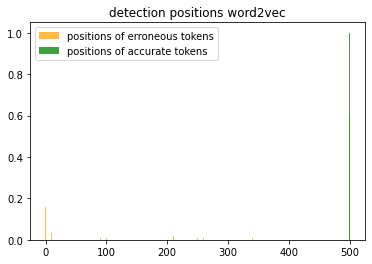

In [61]:
def perc(my_diction):  
    total = 0 
    my_diction = Counter(my_diction)
    for i in my_diction:  
        total = total + my_diction[i]  
    for j in my_diction:  
        my_diction[j] = (float)(my_diction[j])/total  
    return my_diction     

def process_list(my_list):
    #my_list = list(filter(lambda x: x != 500, my_list))
    my_list = [round(x/10)*10 for x in my_list]
    return my_list
                   
                   
        
nep = w2v_non_error_positions
ep = w2v_error_positions
nep = process_list(nep)
ep = process_list(ep)
nep = perc(nep)
ep = perc(ep)
#print('nep:', nep)
#print('ep:', ep)

%matplotlib inline
plt.bar(nep.keys(), nep.values(), alpha = 0.75, label = 'positions of erroneous tokens', color = 'orange')
plt.bar(ep.keys(), ep.values(), alpha = 0.75, label = 'positions of accurate tokens', color = 'green')
plt.legend()
plt.title('detection positions word2vec')

Text(0.5, 1.0, 'detection positions word2vec')

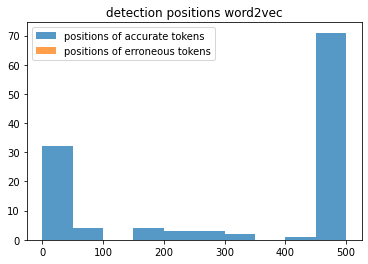

In [62]:
%matplotlib inline
plt.hist(w2v_non_error_positions, alpha = 0.75, label = 'positions of accurate tokens')
plt.hist(w2v_error_positions, alpha = 0.75, label = 'positions of erroneous tokens')
plt.legend()
plt.title('detection positions word2vec')

In [65]:
print('95th percentile GT tokens in candidate list word2vec:', np.percentile(np.array(w2v_right_token_positions), 95))

95th percentile GT tokens in candidate list word2vec: 500.0


In [66]:
#detection and correction validation BERTje
error_positions = [] # the position of a word when it is an error in predictions
non_error_positions = [] # the position of a word when it is not an error in predictions
right_token_positions = []

rights_correct_sorted_list = []
wrongs_correct_sorted_list = []
rights_correct_sorted_nosw_list = []
wrongs_correct_sorted_nosw_list = []
rights_correct_calculated_list = []
wrongs_correct_calculated_list = []

def detection_and_correction_BERTje(row, BERT_model, tokenizer, ocr_names, topn_detection=500):
    
    if row['set'] != 'val':
        return np.nan
    else:
        identifier = row['identifier']
        OCR_text = row['aligned_OCR_sentences']
        GT_text = row['aligned_GT_sentences']
        OCR_text = ast.literal_eval(OCR_text)
        GT_text = ast.literal_eval(GT_text)
        
        # keep track of positions in candidates
        error_positions_doc = []
        non_error_positions_doc = []
        right_token_positions_doc = []
        
        # keep track of performance
        rights_correct_sorted = 0
        wrongs_correct_sorted = 0
        rights_correct_sorted_nosw = 0
        wrongs_correct_sorted_nosw = 0
        rights_correct_calculated = 0
        wrongs_correct_calculated = 0
        
        
        for j in range(len(OCR_text)):
            for i in range(len(OCR_text[j])):
                if (OCR_text[j][i] in ocr_names) or (check_numbers(OCR_text[j][i])== True) or (len(OCR_text[j][i]) <= 2)  or (GT_text[j][i] == 'REMOVED'):
                    continue
                error = True
                if OCR_text[j][i] == GT_text[j][i]:
                    error = False
                candidates = []
                probabilities = []
                # calculate positions detection task
                sentence = copy.deepcopy(OCR_text[j])
                for t in range(len(sentence)):
                    if any(str.isdigit(c) for c in sentence[t]) == True:
                        sentence[t] = '%NUMBER%'
                    elif sentence[t] in ocr_names:
                        sentence[t] = '%NNP%'
                sentence[i] = '[MASK]'
                sentence = ' '.join(sentence)
                pipe = pipeline('fill-mask', model=BERT_model, tokenizer = tokenizer, top_k=topn_detection, device=0)
                for res in pipe(sentence):
                    candidates.append(res['token_str'].replace(' ', ''))
                    probabilities.append(res['score'])
                # remove punctuation except for hyphen from candidates
                candidates = [re.sub(r'[^\w\d\s\-]+', '', x) for x in candidates]
                candidates = [x.lower() for x in candidates]
                try:
                    position = candidates.index(OCR_text[j][i])
                except ValueError:
                    position = topn_detection
                if error == True:
                    # where the error is in the detection list
                    error_positions_doc.append(position)
                    # find where the right word is in the candidates list (same as detection list)
                    try: 
                        position_right_token = candidates.index(GT_text[j][i])
                    except ValueError: 
                        position_right_token = topn_detection
                    right_token_positions_doc.append(position_right_token)
                    # try two correction methods
                    # first calculate the normalized LDs:
                    LD = np.array([fuzz.ratio(OCR_text[j][i], word)/100 for word in candidates])
                    # try sorting method
                    correction = correct_sorted(candidates, probabilities, LD)
                    if correction == GT_text[j][i]:
                        rights_correct_sorted += 1
                    elif correction != GT_text[j][i]:
                        wrongs_correct_sorted += 1
                    # try again the sorting methods, but without stopwords
                    candidates_nostopwords, probabilities_nostopwords, LD_nostopwords = remove_stopwords(candidates, probabilities, LD)
                    correction = correct_sorted(candidates_nostopwords, probabilities_nostopwords, LD_nostopwords)
                    if correction == GT_text[j][i]:
                        rights_correct_sorted_nosw += 1
                    elif correction != GT_text[j][i]:
                        wrongs_correct_sorted_nosw += 1
                    # try score calculation method
                    correction = correct_calculated(candidates, probabilities, LD)
                    if correction == GT_text[j][i]:
                        rights_correct_calculated += 1
                    elif correction != GT_text[j][i]:
                        wrongs_correct_calculated += 1
                elif error == False:
                    # where the non error is in the detection list
                    non_error_positions_doc.append(position)
                # calculate positions correction task
                if error == True:
                    try:
                        right_token_position = candidates.index(GT_text[j][i])
                        right_token_positions_doc.append(right_token_position)
                    except ValueError:
                        right_token_positions_doc.append(topn_detection)
                    right_token_positions.append(right_token_positions_doc)
            
            
    #return error_positions, non_error_positions
    error_positions.append(error_positions_doc)
    non_error_positions.append(non_error_positions_doc)
    right_token_positions.append(right_token_positions_doc)
    
    # add performance to the list
    rights_correct_sorted_list.append(rights_correct_sorted)
    wrongs_correct_sorted_list.append(wrongs_correct_sorted)
    rights_correct_sorted_nosw_list.append(rights_correct_sorted_nosw)
    wrongs_correct_sorted_nosw_list.append(wrongs_correct_sorted_nosw)
    rights_correct_calculated_list.append(rights_correct_calculated)
    wrongs_correct_calculated_list.append(wrongs_correct_calculated)
    
    #return identifier, error_positions, non_error_positions, right_token_positions, rights_correct_sorted_list, wrongs_correct_sorted_list, rights_correct_sorted_nosw_list, wrongs_correct_sorted_nosw_list, rights_correct_calculated_list, wrongs_correct_calculated_list   
    
#for index, row in df.iterrows():
#    detection_word2vec(row)
# df.loc[70]
fake_test_list_GT_aligned = """Een koekenpan of kortweg pan is een platte pan met een lang handvat.
De pan ontleent zijn naam aan het feit dat in zo'n pan pannenkoeken worden gebakken. Ook ander voedsel, zoals vlees, wordt in een koekenpan gebraden"""
fake_test_list_OCR_aligned = """Een hoekenpan of kortweg pan is een platte pan met een hang handvat.
De pan ontleent zijn naam haan het feit dat in zo'n pan pannenkoeken horden gebakken. Ook ander voedsel, zoals vlees, word in een hoekenpan gebraden"""
fake_test_list_GT_aligned = fake_test_list_GT_aligned.split('.')
fake_test_list_OCR_aligned = fake_test_list_OCR_aligned.split('.')
fake_test_list_GT_aligned = [x.split(' ') for x in fake_test_list_GT_aligned]
fake_test_list_OCR_aligned = [x.split(' ') for x in fake_test_list_OCR_aligned]
d = {'identifier': ['111'], 'aligned_OCR_sentences': [str(fake_test_list_OCR_aligned)], 'aligned_GT_sentences': [str(fake_test_list_GT_aligned)], 'set': ['val']}
df_probeer = pd.DataFrame(data=d)


#identifier, BERT_error_positions, BERT_non_error_positions, BERT_right_token_positions, rights_correct_sorted_list, wrongs_correct_sorted_list, rights_correct_sorted_nosw_list, wrongs_correct_sorted_nosw_list, rights_correct_calculated_list, wrongs_correct_calculated_list = detection_and_correction_BERTje(df_probeer.loc[0], BERT_model, tokenizer, ocr_names)
#for index, row in df.loc[df['set'].isin(['val'])].iterrows():
#    if (index == 70) or (index == 72):
#        print('index:', index)
#        identifier, BERT_error_positions, BERT_non_error_positions, BERT_right_token_positions, rights_correct_sorted_list, wrongs_correct_sorted_list, rights_correct_sorted_nosw_list, wrongs_correct_sorted_nosw_list, rights_correct_calculated_list, wrongs_correct_calculated_list = detection_and_correction_BERTje(row, BERT_model, tokenizer, ocr_names)
#    else:
#        print('passed')
for index, row in df.loc[df['set'].isin(['val'])].iterrows():
    if index%1000 == 0:
        print(index)
    detection_and_correction_BERTje(row, BERT_model, tokenizer, ocr_names)





In [67]:
# analysis of performance on validation set BERTje
#d = {'error_positions in detection': error_positions, 'non_error_positions in detection': non_error_positions}
#validation_df_positions = pd.DataFrame(data = d)
d = {'rights_correct_sorted_list': rights_correct_sorted_list, 'wrongs_correct_sorted_list': wrongs_correct_sorted_list, \
    'rights_correct_sorted_nosw_list': rights_correct_sorted_nosw_list, 'wrongs_correct_sorted_nosw_list': wrongs_correct_sorted_nosw_list, \
    'rights_correct_calculated_list': rights_correct_calculated_list, 'wrongs_correct_calculated_list': wrongs_correct_calculated_list}
validation_df_correction_methods_BERTje = pd.DataFrame(data = d)

#print(BERT_right_token_positions)
#print(BERT_right_token_positions)
#print(BERT_right_token_positions)
#print(error_positions)
BERT_error_positions = list_merger(error_positions)
BERT_non_error_positions = list_merger(non_error_positions)
BERT_right_token_positions = list_merger(right_token_positions)
#print('errors:', s.mean(BERT_error_positions))
#print('non errors:', s.mean(BERT_non_error_positions))
#print('right token in prediction:', s.mean(BERT_right_token_positions))

for method in ['correct_sorted', 'correct_sorted_nosw', 'correct_calculated']:
    rights = np.array(validation_df_correction_methods_BERTje[f'rights_{method}_list'])
    wrongs = np.array(validation_df_correction_methods_BERTje[f'wrongs_{method}_list'])
    validation_df_correction_methods_BERTje[f'accuracy {method}'] = list(rights/(rights + wrongs))

#validation_df_correction_methods_BERTje.head()

errors: 500
non errors: 330.15503875968994
right token in prediction: 268.7857142857143


<ipython-input-67-129b0aa244fe>:23: RuntimeWarning: invalid value encountered in true_divide
  validation_df_correction_methods_BERTje[f'accuracy {method}'] = list(rights/(rights + wrongs))


,rights_correct_sorted_list,wrongs_correct_sorted_list,rights_correct_sorted_nosw_list,wrongs_correct_sorted_nosw_list,rights_correct_calculated_list,wrongs_correct_calculated_list,accuracy correct_sorted,accuracy correct_sorted_nosw,accuracy correct_calculated
0,0,2,0,2,0,2,0.0,0.00,0.00
1,0,0,0,0,0,0,NaN,NaN,NaN
2,2,2,1,3,1,3,0.5,0.25,0.25
3,0,1,0,1,0,1,0.0,0.00,0.00


In [68]:
acc_columns = (validation_df_correction_methods_BERTje.filter(regex='accuracy').columns).tolist()
print('Mean accuracies for BERT:')
print(validation_df_correction_methods_BERTje[acc_columns].mean())
print('Accuracies standard deviation for BERT:')
print(validation_df_correction_methods_BERTje[acc_columns].std())

Mean accuracies for BERT:
accuracy correct_sorted         0.166667
accuracy correct_sorted_nosw    0.083333
accuracy correct_calculated     0.083333
dtype: float64
Accuracies standard deviation for BERT:
accuracy correct_sorted         0.288675
accuracy correct_sorted_nosw    0.144338
accuracy correct_calculated     0.144338
dtype: float64


nep: Counter({500: 0.6124031007751938, 0: 0.16279069767441862, 10: 0.05426356589147287, 20: 0.03875968992248062, 160: 0.015503875968992248, 30: 0.015503875968992248, 40: 0.015503875968992248, 460: 0.015503875968992248, 270: 0.007751937984496124, 410: 0.007751937984496124, 140: 0.007751937984496124, 70: 0.007751937984496124, 50: 0.007751937984496124, 90: 0.007751937984496124, 240: 0.007751937984496124, 110: 0.007751937984496124, 130: 0.007751937984496124})
ep: Counter({500: 1.0})


Text(0.5, 1.0, 'detection positions BERT')

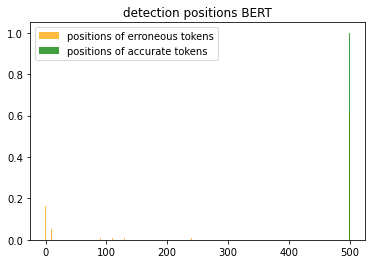

In [69]:
%matplotlib inline
def perc(my_diction):  
    total = 0 
    my_diction = Counter(my_diction)
    for i in my_diction:  
        total = total + my_diction[i]  
    for j in my_diction:  
        my_diction[j] = (float)(my_diction[j])/total  
    return my_diction     

def process_list(my_list):
    #my_list = list(filter(lambda x: x != 500, my_list))
    my_list = [round(x/10)*10 for x in my_list]
    return my_list
                   
                   
        
nep = BERT_non_error_positions
ep = BERT_error_positions
nep = process_list(nep)
ep = process_list(ep)
nep = perc(nep)
ep = perc(ep)
#print('nep:', nep)
#print('ep:', ep)

plt.bar(nep.keys(), nep.values(), alpha = 0.75, label = 'positions of erroneous tokens', color = 'orange')
plt.bar(ep.keys(), ep.values(), alpha = 0.75, label = 'positions of accurate tokens', color = 'green')
plt.legend()
plt.title('detection positions BERT')

In [70]:
print('95th percentile GT tokens in candidate list BERT:', np.percentile(np.array(BERT_right_token_positions), 95))

95th percentile GT tokens in candidate list BERT: 500.0


In [71]:
# save important information
# BERT: error_positions, non_error_positions, right_token_positions
BERT_positions = [BERT_error_positions, BERT_non_error_positions, BERT_right_token_positions]
with open('BERT_positions.txt', 'wb') as f:
    pickle.dump(BERT_positions, f)
# word2vec: error_positions, non_error_positions, right_token_positions
w2v_positions = [w2v_error_positions, w2v_non_error_positions, w2v_right_token_positions]
with open('word2vec_positions.txt', 'wb') as f:
    pickle.dump(w2v_positions, f)
# BERT validation df
validation_df_correction_methods_BERTje.to_csv('validation_BERT.csv')
# word2vec validation df
validation_df_correction_methods_word2vec.to_csv('validation_word2vec.csv')

In [72]:
#old_sentence = "Die [MASK] hadde viele avontuere ghemaect."
#new_sentence = "De [MASK] had vele avonturen gemaakt."
#pipe = pipeline('fill-mask', model=BERT_model, tokenizer = tokenizer, top_k=5)
#for res in pipe(new_sentence):
#    print(res['token_str'].replace(' ', ''))
#    print(res['score'])
#    pipe = pipeline('fill-mask', model=BERT_model, tokenizer = tokenizer, top_k=5)
#for res in pipe(old_sentence):
#    print(res['token_str'].replace(' ', ''))
#    print(res['score'])